In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

Cloning into 'new-simple-point-clouds'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.15 MiB | 7.17 MiB/s, done.


In [3]:
!pip install plyfile

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData

# Define the PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 3 * 500)  # Adjust output size to 3 * 1024

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x.view(-1, 3, 500)  # Reshape to match desired output shape

# Define the PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load your own real-life point cloud data (replace this with your actual data loading)
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = np.column_stack((x, y, z)).astype(np.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    # Resample point cloud to a fixed number of points
    print("Original size ", len(point_cloud))
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

# Preprocess the loaded point cloud data
def preprocess_point_cloud(point_cloud_data):
    # Add any necessary preprocessing steps here
    # For example, normalization, resizing, etc.
    # Ensure the shape of the point cloud data matches the expected input shape of the model
    return resample_point_cloud(point_cloud_data, 500)

# Define the file path to your point cloud data
point_cloud_file_path = "/content/new-simple-point-clouds/circle_point_cloud.ply"

# Load and preprocess your point cloud data
point_cloud_data = load_point_cloud_from_ply(point_cloud_file_path)
point_cloud_data = preprocess_point_cloud(point_cloud_data)

# Convert the NumPy array to a PyTorch tensor and transpose it
point_cloud_tensor = torch.tensor(point_cloud_data, dtype=torch.float32).transpose(0, 1)

# Add a batch dimension to the tensor
point_cloud_tensor = point_cloud_tensor.unsqueeze(0)

# Create an instance of the PointNet Autoencoder
model = PointNetAutoencoder()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(point_cloud_tensor)

    # print("Output shape:", outputs.shape)
    # print("Target shape:", point_cloud_tensor.shape)

    # Compute the reconstruction loss
    loss = criterion(outputs, point_cloud_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Original size  500
Epoch [10/100], Loss: 0.2296
Epoch [20/100], Loss: 0.2181
Epoch [30/100], Loss: 0.2136
Epoch [40/100], Loss: 0.2118
Epoch [50/100], Loss: 0.2116
Epoch [60/100], Loss: 0.2109
Epoch [70/100], Loss: 0.2109
Epoch [80/100], Loss: 0.2108
Epoch [90/100], Loss: 0.2108
Epoch [100/100], Loss: 0.2108


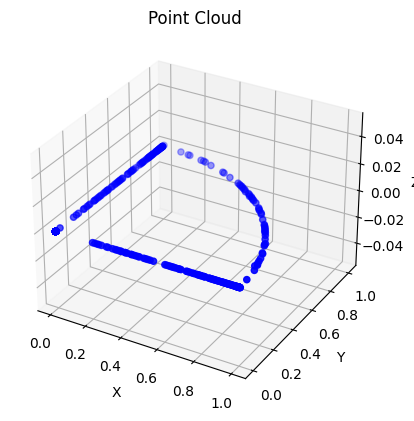

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud, title='Point Cloud'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='b', marker='o')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Convert the PyTorch tensor to a NumPy array for visualization
reconstructed_point_cloud_np = outputs.squeeze().detach().cpu().numpy()

# Plot the reconstructed point cloud
plot_point_cloud(reconstructed_point_cloud_np.transpose(1, 0))
